In [1]:
import sklearn
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from copy import deepcopy       
from functools import partial
!pip install xgboost
import xgboost as xgb
!pip install catboost
!pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

You should consider upgrading via the 'C:\Users\Owner\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Owner\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_internal\commands\install.py:229: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
You should consider upgrading via the 'C:\Users\Owner\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
train_data=pd.read_csv('C:/Users/Owner/Desktop/data/train/train.csv')
test_data=pd.read_csv('C:/Users/Owner/Desktop/data/test/test.csv')

print('The dimension of the train dataset is:', train_data.shape)
print('The dimension of the test dataset is:', test_data.shape)

The dimension of the train dataset is: (13228, 19)
The dimension of the test dataset is: (13229, 19)


In [3]:
train_data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,0,F,Y,Y,0,202500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19031,365243,1,0,0,0,NaN,2,-53
1,1,F,N,N,1,157500.0,Working,Higher education,Married,House / apartment,-15773,-309,1,0,1,0,Sales staff,3,-26
2,2,M,Y,N,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-13483,-1816,1,1,1,0,Laborers,2,-9
3,3,F,Y,N,2,112500.0,Working,Secondary / secondary special,Married,House / apartment,-12270,-150,1,0,1,0,Security staff,4,-12
4,4,M,Y,Y,1,225000.0,Working,Secondary / secondary special,Married,House / apartment,-16175,-2371,1,0,0,0,Drivers,3,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13223,13223,F,N,N,0,225000.0,Working,Secondary / secondary special,Widow,House / apartment,-20657,-5637,1,0,0,0,Accountants,1,-43
13224,13224,F,Y,Y,0,292500.0,Commercial associate,Higher education,Married,House / apartment,-18409,-3482,1,0,0,0,Sales staff,2,-53
13225,13225,F,N,Y,0,135000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-14625,-7827,1,0,1,1,NaN,2,-34
13226,13226,M,N,Y,1,157500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-10676,-2326,1,0,1,1,Laborers,3,-16


In [4]:
test_data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,0,M,N,Y,0,211500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10072,-1101,1,1,1,0,Core staff,1,-10
1,1,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-24340,365243,1,0,1,0,NaN,1,-52
2,2,F,N,Y,0,45000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15724,-1389,1,1,1,0,Sales staff,2,-15
3,3,M,N,Y,2,270000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-11505,-4019,1,0,0,0,Laborers,3,-24
4,4,F,N,Y,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-15929,-2879,1,0,1,0,Laborers,2,-54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13224,13224,F,N,Y,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-12347,-2057,1,0,0,0,Laborers,2,-30
13225,13225,M,N,Y,0,148500.0,Commercial associate,Higher education,Single / not married,House / apartment,-9382,-2049,1,0,1,1,Medicine staff,1,-24
13226,13226,M,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14896,-5420,1,0,0,1,Drivers,2,-26
13227,13227,M,N,Y,0,405000.0,Working,Higher education,Married,House / apartment,-15881,-4781,1,1,0,0,Laborers,2,-30


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13228 entries, 0 to 13227
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          13228 non-null  int64  
 1   gender         13228 non-null  object 
 2   car            13228 non-null  object 
 3   reality        13228 non-null  object 
 4   child_num      13228 non-null  int64  
 5   income_total   13228 non-null  float64
 6   income_type    13228 non-null  object 
 7   edu_type       13228 non-null  object 
 8   family_type    13228 non-null  object 
 9   house_type     13228 non-null  object 
 10  DAYS_BIRTH     13228 non-null  int64  
 11  DAYS_EMPLOYED  13228 non-null  int64  
 12  FLAG_MOBIL     13228 non-null  int64  
 13  work_phone     13228 non-null  int64  
 14  phone          13228 non-null  int64  
 15  email          13228 non-null  int64  
 16  occyp_type     9096 non-null   object 
 17  family_size    13228 non-null  int64  
 18  begin_

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13229 entries, 0 to 13228
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          13229 non-null  int64  
 1   gender         13229 non-null  object 
 2   car            13229 non-null  object 
 3   reality        13229 non-null  object 
 4   child_num      13229 non-null  int64  
 5   income_total   13229 non-null  float64
 6   income_type    13229 non-null  object 
 7   edu_type       13229 non-null  object 
 8   family_type    13229 non-null  object 
 9   house_type     13229 non-null  object 
 10  DAYS_BIRTH     13229 non-null  int64  
 11  DAYS_EMPLOYED  13229 non-null  int64  
 12  FLAG_MOBIL     13229 non-null  int64  
 13  work_phone     13229 non-null  int64  
 14  phone          13229 non-null  int64  
 15  email          13229 non-null  int64  
 16  occyp_type     9190 non-null   object 
 17  family_size    13229 non-null  int64  
 18  begin_

In [7]:
train_labels = pd.read_csv('C:/Users/Owner/Desktop/data/train/train_label.csv')
train_labels

,index,credit
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
13223,13223,1
13224,13224,1
13225,13225,1
13226,13226,1


In [8]:
test_labels = pd.read_csv('C:/Users/Owner/Desktop/data/test/test_label.csv')
test_labels

,index,credit
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
13224,13224,NaN
13225,13225,NaN
13226,13226,NaN
13227,13227,NaN


## EDA

In [9]:
train_data_describe = train_data.describe()
missing_values = train_data.isnull().sum()

train_data_describe, missing_values[missing_values > 0]

(              index     child_num  income_total    DAYS_BIRTH  DAYS_EMPLOYED  \
 count  13228.000000  13228.000000  1.322800e+04  13228.000000   13228.000000   
 mean    6613.500000      0.428107  1.888212e+05 -15958.143408   59854.037496   
 std     3818.739015      0.740691  1.041743e+05   4199.720373  138166.424477   
 min        0.000000      0.000000  2.700000e+04 -25152.000000  -15713.000000   
 25%     3306.750000      0.000000  1.215000e+05 -19406.500000   -3153.000000   
 50%     6613.500000      0.000000  1.575000e+05 -15521.500000   -1539.000000   
 75%     9920.250000      1.000000  2.250000e+05 -12454.000000    -401.750000   
 max    13227.000000     14.000000  1.575000e+06  -7705.000000  365243.000000   
 
        FLAG_MOBIL    work_phone         phone         email   family_size  \
 count     13228.0  13228.000000  13228.000000  13228.000000  13228.000000   
 mean          1.0      0.230269      0.296946      0.089507      2.192773   
 std           0.0      0.421021   

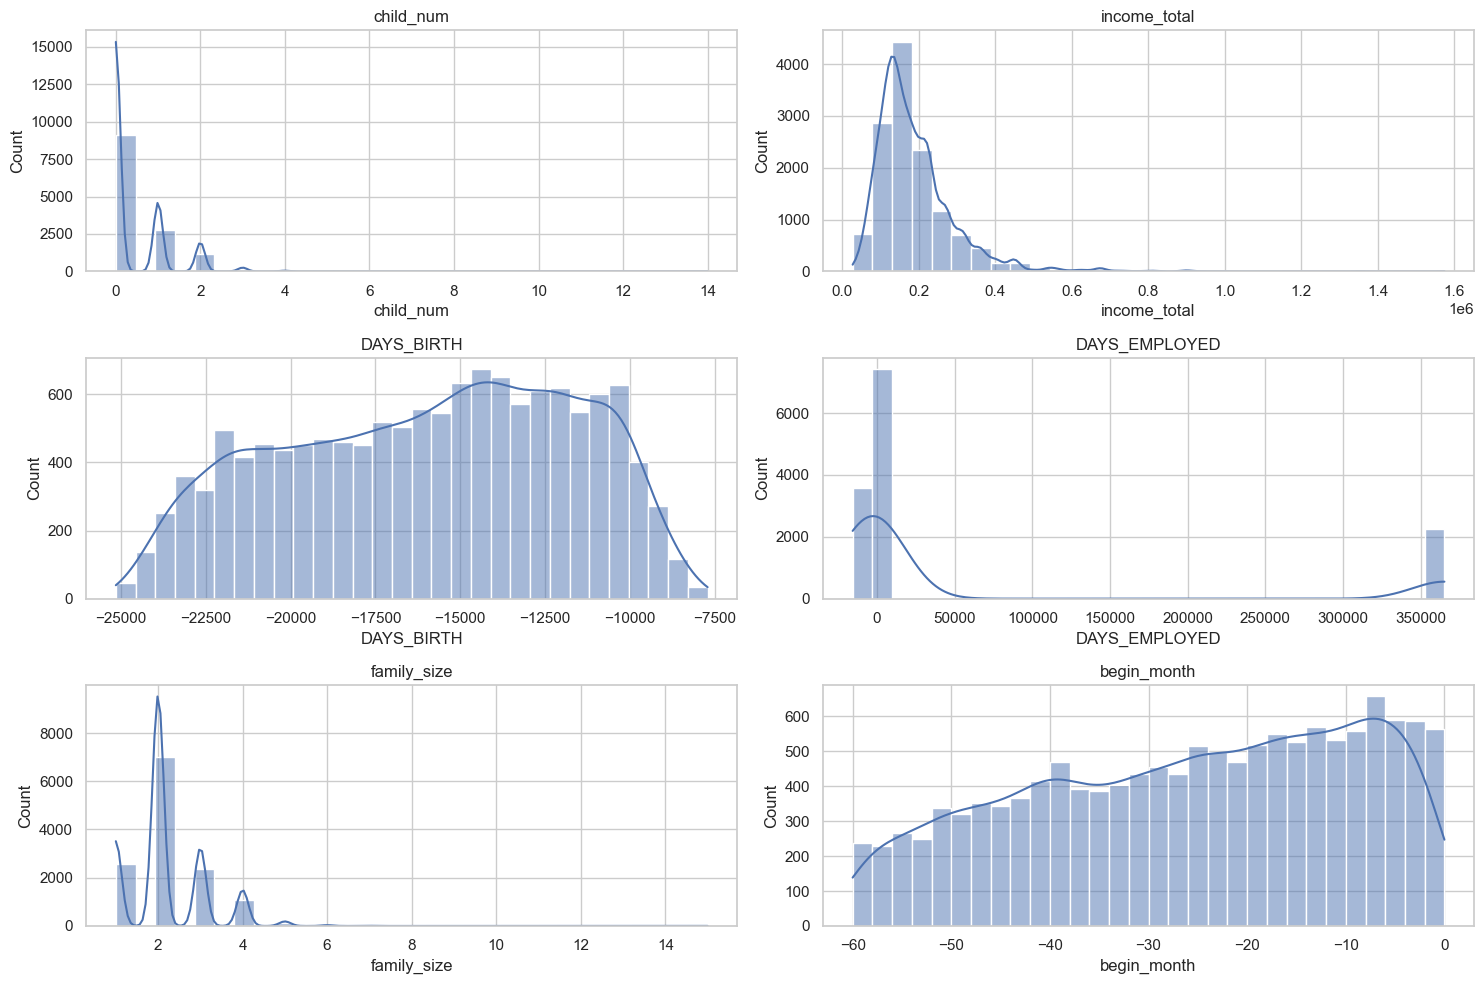

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

numerical_columns = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(train_data[column], kde=True, bins=30)
    plt.title(column)
    plt.tight_layout()

plt.show()

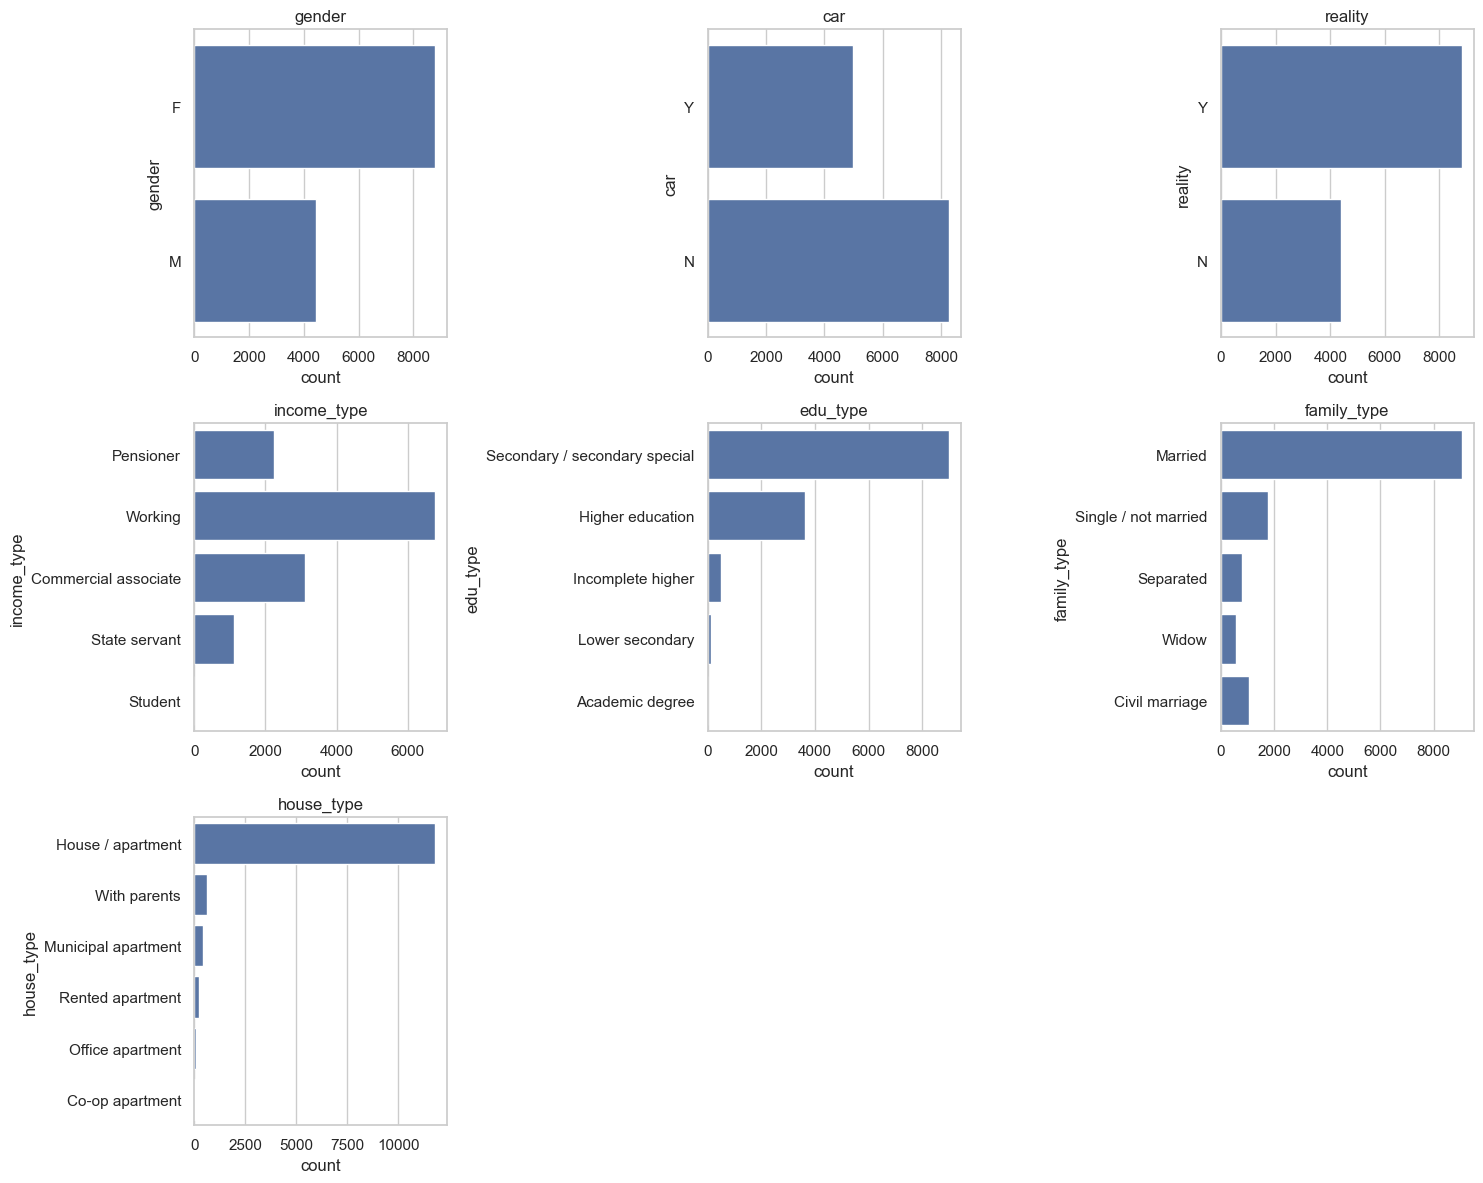

In [11]:
categorical_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type']

plt.figure(figsize=(15, 12))
for i, column in enumerate(categorical_columns):
    plt.subplot(3, 3, i + 1)
    sns.countplot(y=train_data[column])
    plt.title(column)
    plt.tight_layout()

plt.show()

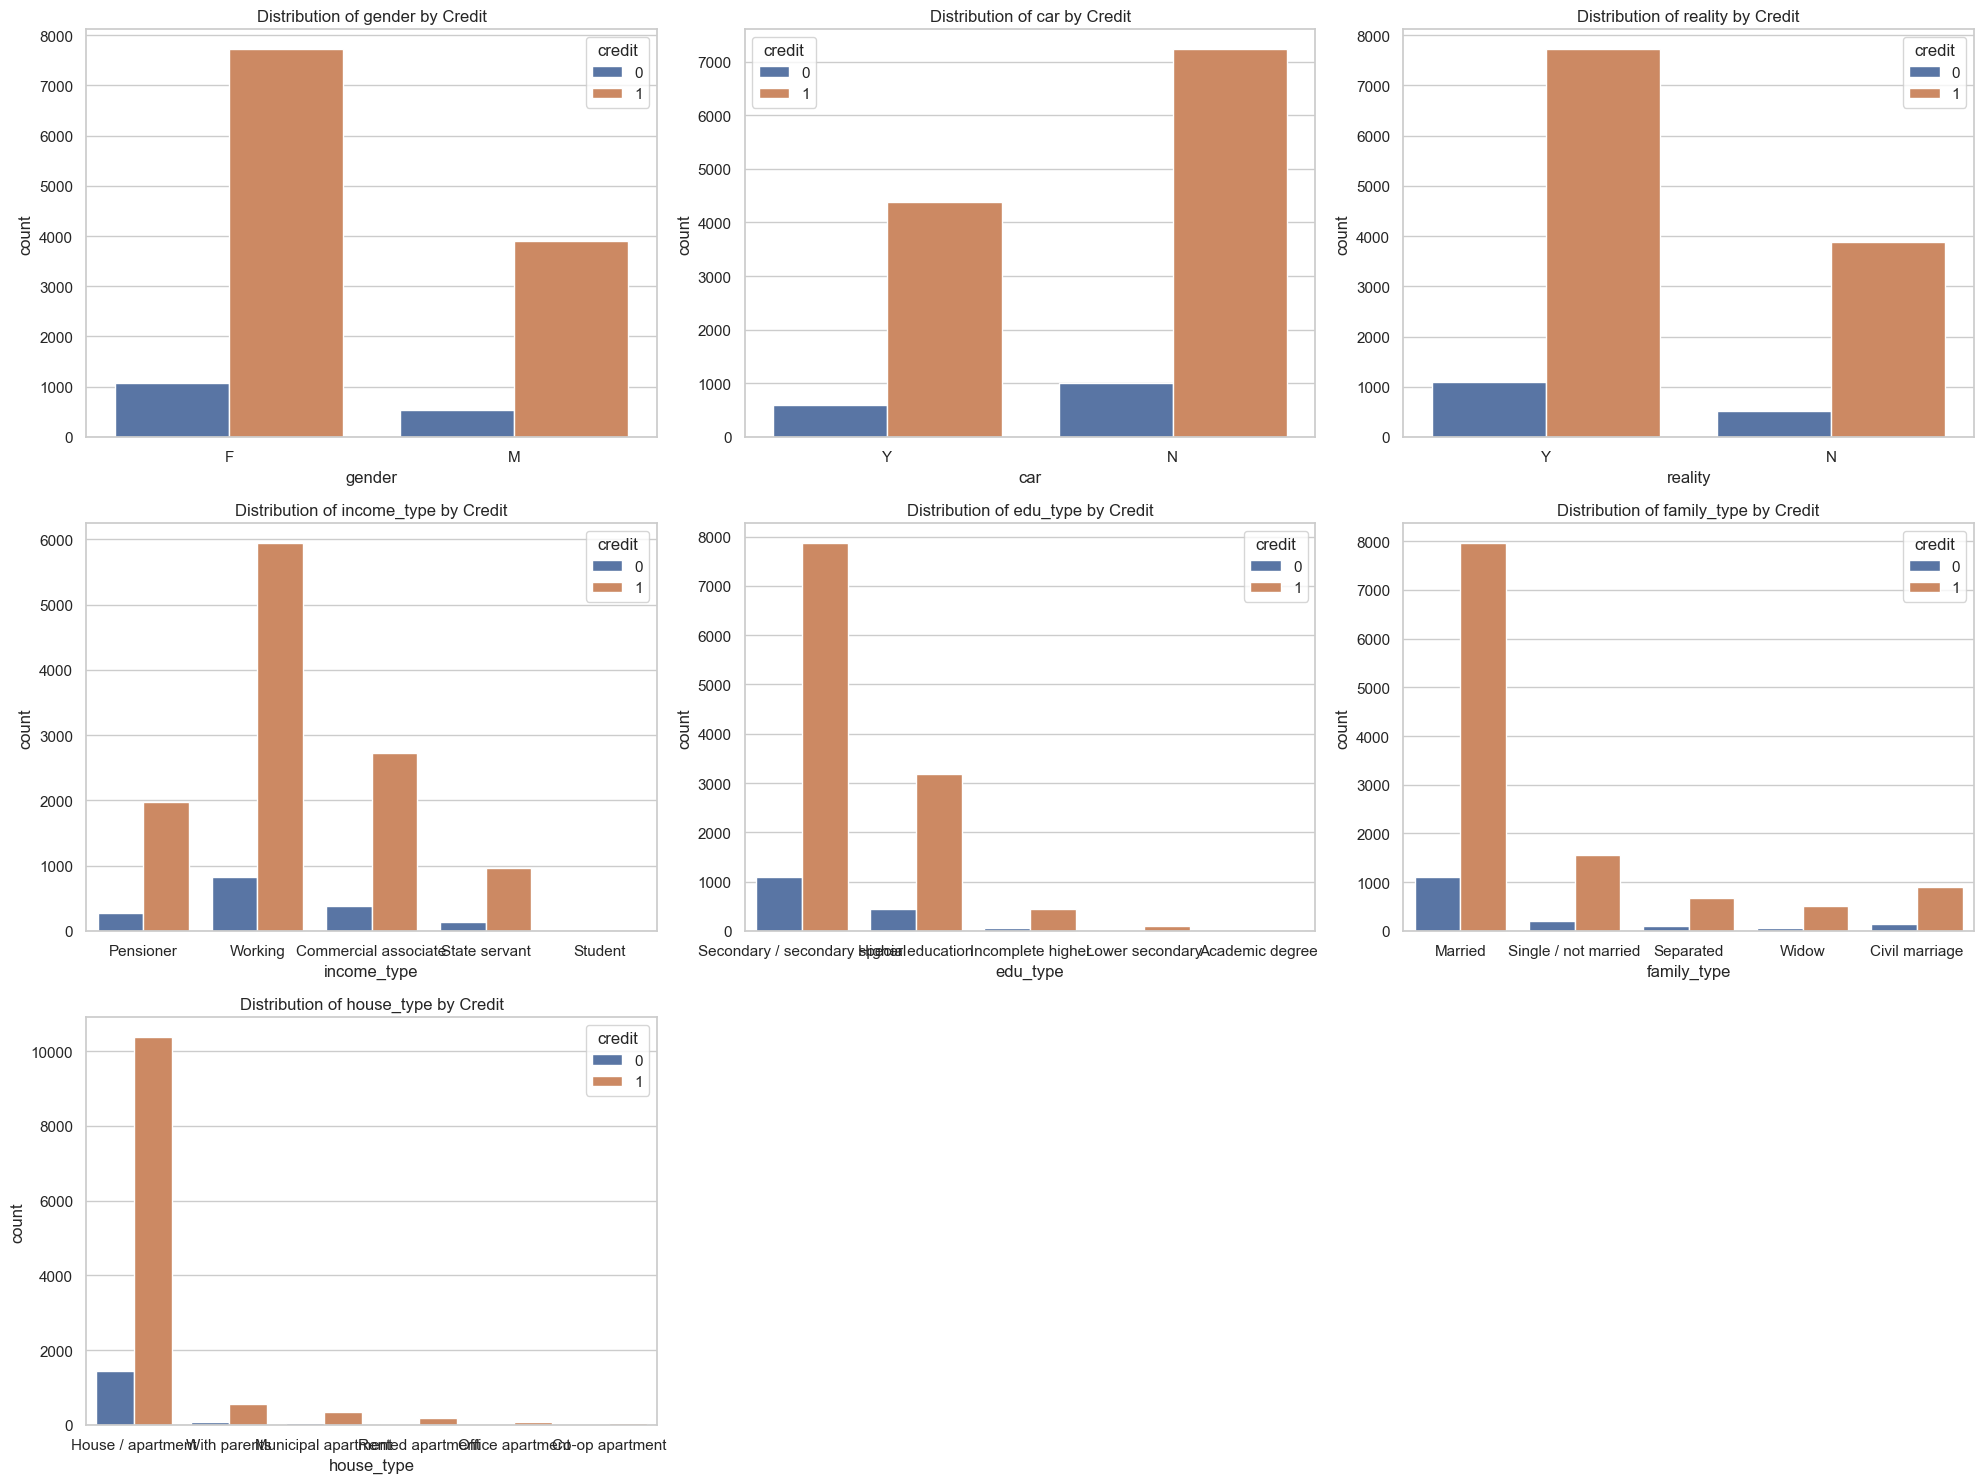

In [12]:
train_data_merged = pd.merge(train_data, train_labels, on="index")

selected_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type']

plt.figure(figsize=(20, 15))
for i, col in enumerate(selected_columns):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=col, hue='credit', data=train_data_merged)
    plt.title(f"Distribution of {col} by Credit")
    plt.tight_layout()

plt.show()

## Feature Engineering

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

fe_train_data = train_data.copy()

# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

for col in categorical_columns:
    fe_train_data[col] = fe_train_data[col].fillna('Unknown')
    fe_train_data[col] = label_encoder.fit_transform(fe_train_data[col])

# numerical columns
numerical_columns = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']
fe_train_data[numerical_columns] = fe_train_data[numerical_columns].fillna(fe_train_data[numerical_columns].mean())

# Standard Scaling
scaler = StandardScaler()
fe_train_data[numerical_columns] = scaler.fit_transform(fe_train_data[numerical_columns])

# Creating features age and years_employed
fe_train_data['age'] = fe_train_data['DAYS_BIRTH'] / -365
fe_train_data['years_employed'] = fe_train_data['DAYS_EMPLOYED'].apply(lambda x: x / -365 if x < 0 else 0)

fe_train_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,age,years_employed
0,0,0,1,1,-0.578006,0.131311,1,4,1,1,-0.731709,2.210381,1,0,0,0,17,-0.211739,-1.616608,0.002005,0.000000
1,1,0,0,0,0.772137,-0.300673,4,1,1,1,0.044086,-0.435455,1,0,1,0,14,0.886645,0.011960,-0.000121,0.001193
2,2,1,1,0,-0.578006,-0.516665,4,4,1,1,0.589381,-0.446363,1,1,1,0,8,-0.211739,1.037355,-0.001615,0.001223
3,3,0,1,0,2.122279,-0.732658,4,4,1,1,0.878221,-0.434305,1,0,1,0,16,1.985029,0.856403,-0.002406,0.001190
4,4,1,1,1,0.772137,0.347304,4,4,1,1,-0.051638,-0.450380,1,0,0,0,4,0.886645,1.399260,0.000141,0.001234


In [14]:
# Combine train and test
combined_data = pd.concat([train_data, test_data], keys=['train', 'test'])

for col in categorical_columns:
    combined_data[col] = combined_data[col].fillna('Unknown')
    combined_data[col] = label_encoder.fit_transform(combined_data[col])

# Split train and test
fe_train_data = combined_data.xs('train')
fe_test_data = combined_data.xs('test')

fe_test_data[numerical_columns] = scaler.transform(fe_test_data[numerical_columns])

# Creating features age and years_employed
fe_test_data['age'] = fe_test_data['DAYS_BIRTH'] / -365
fe_test_data['years_employed'] = fe_test_data['DAYS_EMPLOYED'].apply(lambda x: x / -365 if x < 0 else 0)

fe_test_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,age,years_employed
0,0,1,0,1,-0.578006,0.217708,4,4,3,1,1.401609,-0.441188,1,1,1,0,3,-1.310122,0.977038,-0.003840,0.001209
1,1,0,0,1,-0.578006,-0.300673,1,4,4,1,-1.995888,2.210381,1,0,1,0,17,-1.310122,-1.556291,0.005468,0.000000
2,2,0,0,1,-0.578006,-1.380634,0,4,1,1,0.055754,-0.443272,1,1,1,0,14,-0.211739,0.675451,-0.000153,0.001214
3,3,1,0,1,2.122279,0.779288,4,4,3,1,1.060383,-0.462308,1,0,0,0,8,0.886645,0.132595,-0.002905,0.001267
4,4,0,0,1,-0.578006,0.131311,4,4,1,1,0.006940,-0.454057,1,0,1,0,8,-0.211739,-1.676925,-0.000019,0.001244


In [15]:
# Add age and years_employed to train_data
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

for col in categorical_columns:
    fe_train_data[col] = fe_train_data[col].fillna('Unknown')
    fe_train_data[col] = label_encoder.fit_transform(fe_train_data[col])

# numerical columns
numerical_columns = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']
fe_train_data[numerical_columns] = fe_train_data[numerical_columns].fillna(fe_train_data[numerical_columns].mean())

# Standard Scaling
scaler = StandardScaler()
fe_train_data[numerical_columns] = scaler.fit_transform(fe_train_data[numerical_columns])

# Creating features age and years_employed
fe_train_data['age'] = fe_train_data['DAYS_BIRTH'] / -365
fe_train_data['years_employed'] = fe_train_data['DAYS_EMPLOYED'].apply(lambda x: x / -365 if x < 0 else 0)

fe_train_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,age,years_employed
0,0,0,1,1,-0.578006,0.131311,1,4,1,1,-0.731709,2.210381,1,0,0,0,17,-0.211739,-1.616608,0.002005,0.000000
1,1,0,0,0,0.772137,-0.300673,4,1,1,1,0.044086,-0.435455,1,0,1,0,14,0.886645,0.011960,-0.000121,0.001193
2,2,1,1,0,-0.578006,-0.516665,4,4,1,1,0.589381,-0.446363,1,1,1,0,8,-0.211739,1.037355,-0.001615,0.001223
3,3,0,1,0,2.122279,-0.732658,4,4,1,1,0.878221,-0.434305,1,0,1,0,16,1.985029,0.856403,-0.002406,0.001190
4,4,1,1,1,0.772137,0.347304,4,4,1,1,-0.051638,-0.450380,1,0,0,0,4,0.886645,1.399260,0.000141,0.001234


## Validation Setting

In [16]:
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.model_selection import train_test_split

random_state = 0
X_train = fe_train_data.drop(['index'], axis=1)  
y_train = train_labels['credit']
X_test = fe_test_data.drop(['index'], axis=1)  
y_test = test_labels['credit']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)


## Modeling

In [17]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout

In [18]:
sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
rms = tensorflow.keras.optimizers.RMSprop()
adam=tensorflow.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam"
)
lrelu = lambda x: tensorflow.keras.activations.relu(x, alpha=0.1)


In [20]:
ann = Sequential()
ann.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation=lrelu))
ann.add(Dropout(0.1))
ann.add(Dense(16,  kernel_initializer='he_uniform', activation=lrelu))
ann.add(Dropout(0.1))
ann.add(Dense(4,  kernel_initializer='he_uniform', activation='relu'))
ann.add(Dropout(0.1))

ann.add(Dense(1,  kernel_initializer='he_uniform', activation='sigmoid'))
ann.compile(loss="binary_crossentropy", optimizer=adam,metrics=['accuracy'])

In [21]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.155,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
            
        xgb_params2=xgb_params.copy() 
        xgb_params2['subsample']= 0.3
        xgb_params2['max_depth']=8
        xgb_params2['learning_rate']=0.005
        xgb_params2['colsample_bytree']=0.9

        xgb_params3=xgb_params.copy() 
        xgb_params3['subsample']= 0.6
        xgb_params3['max_depth']=6
        xgb_params3['learning_rate']=0.0125
        xgb_params3['colsample_bytree']=0.7      
        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 8,
            'learning_rate': 0.0125,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            #'enable_categorical':True
        }
        lgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 6,
            'learning_rate': 0.0375,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
        }
        lgb_params3=lgb_params.copy()  
        lgb_params3['subsample']=0.9
        lgb_params3['reg_lambda']=0.3461495211744402
        lgb_params3['reg_alpha']=0.3095626288582237
        lgb_params3['max_depth']=8
        lgb_params3['learning_rate']=0.0075
        lgb_params3['colsample_bytree']=0.5

        lgb_params4=lgb_params2.copy()  
        lgb_params4['subsample']=0.7
        lgb_params4['reg_lambda']=0.1
        lgb_params4['reg_alpha']=0.2
        lgb_params4['max_depth']=10
        lgb_params4['learning_rate']=0.00375
        lgb_params4['colsample_bytree']=0.5
        dt_params= {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 8, 'criterion': 'gini'}
        
        models = {
            'xgb': xgb.XGBClassifier(**xgb_params),
            'xgb2': xgb.XGBClassifier(**xgb_params2),
            'xgb3': xgb.XGBClassifier(**xgb_params3),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'lgb2': lgb.LGBMClassifier(**lgb_params2),
            'lgb3': lgb.LGBMClassifier(**lgb_params3),
            'lgb4': lgb.LGBMClassifier(**lgb_params4),
            'hist_gbm' : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,  max_leaf_nodes=80,
                                                         max_depth=6,random_state=self.random_state),#class_weight=class_weights_dict, 
            'lr': LogisticRegression(),
            'rf': RandomForestClassifier(max_depth= 9,max_features= 'auto',min_samples_split= 10,
                                                          min_samples_leaf= 4,  n_estimators=500,random_state=self.random_state),
            'ann':ann
        }
        return models

## Optuna

In [22]:
!pip install cmaes
import optuna

class OptunaWeights:
    def __init__(self, random_state, n_trials=3000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        weights = [trial.suggest_float(f"weight{n}", -1, 3) for n in range(len(y_preds))]
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)
        
        threshold = 0.5
        binary_pred = (weighted_pred > threshold).astype(int)

        f1_score_value = f1_score(y_true, binary_pred)
        return f1_score_value


    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

You should consider upgrading via the 'C:\Users\Owner\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


## K-Fold Validation

In [23]:
import gc
from sklearn.metrics import f1_score
kfold = True
n_splits = 1 if not kfold else 5
random_state = 2023
random_state_list = [42] 
n_estimators = 9999
early_stopping_rounds = 300
verbose = False

splitter = Splitter(kfold=kfold, n_splits=n_splits)
global device
device = 'cpu'

test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[]}

y_train_binary = (y_train_split > 0).astype(int)
y_val_binary = (y_val_split > 0).astype(int)
    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train_split, y_train_binary, random_state_list=random_state_list)):
    
    n = i % n_splits
    m = i // n_splits
            
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    oof_preds = []
    test_preds = []
    
    for name, model in models.items():
        if 'lgb' == name: # LightGBM model
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)],
                      early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        elif 'xgb' == name: # XGBoost model
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        elif name in 'ann': # ANN model
            model.fit(X_train_, y_train_, validation_data=(X_val, y_val),batch_size=4, epochs=5,verbose=verbose)
        else:
            model.fit(X_train_, y_train_)
        
        if name in 'ann':
            test_pred = np.where(np.array(model.predict(X_test))[:, 0] > 0.5, 1, 0)
            y_val_pred = np.where(np.array(model.predict(X_val))[:, 0] > 0.5, 1, 0)
        else:
            test_pred = np.where(model.predict_proba(X_test)[:, 1] > 0.5, 1, 0)
            y_val_pred = np.where(model.predict_proba(X_val)[:, 1] > 0.5, 1, 0)
        
        score = f1_score(y_val, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] F1 score: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
        
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))

    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    score = f1_score(y_val, np.where(y_val_pred > 0.5, 1, 0))
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] ------------------>  F1 score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    test_predss += optweights.predict(test_preds)
    
    gc.collect()
test_predss /= (n_splits * len(random_state_list))

xgb [FOLD-0 SEED-42] F1 score: 0.93672
xgb2 [FOLD-0 SEED-42] F1 score: 0.93182
xgb3 [FOLD-0 SEED-42] F1 score: 0.92870
lgb [FOLD-0 SEED-42] F1 score: 0.93756
lgb2 [FOLD-0 SEED-42] F1 score: 0.92464
lgb3 [FOLD-0 SEED-42] F1 score: 0.93182
lgb4 [FOLD-0 SEED-42] F1 score: 0.93595
hist_gbm [FOLD-0 SEED-42] F1 score: 0.93672
lr [FOLD-0 SEED-42] F1 score: 0.93672
rf [FOLD-0 SEED-42] F1 score: 0.93672
67/67 [==============================] - 0s 2ms/step
ann [FOLD-0 SEED-42] F1 score: 0.93672
Ensemble [FOLD-0 SEED-42] ------------------>  F1 score 0.93807
xgb [FOLD-1 SEED-42] F1 score: 0.93958
xgb2 [FOLD-1 SEED-42] F1 score: 0.93603
xgb3 [FOLD-1 SEED-42] F1 score: 0.92900
lgb [FOLD-1 SEED-42] F1 score: 0.93843
lgb2 [FOLD-1 SEED-42] F1 score: 0.92962
lgb3 [FOLD-1 SEED-42] F1 score: 0.93582
lgb4 [FOLD-1 SEED-42] F1 score: 0.93702
hist_gbm [FOLD-1 SEED-42] F1 score: 0.93911
lr [FOLD-1 SEED-42] F1 score: 0.93911
rf [FOLD-1 SEED-42] F1 score: 0.93858
67/67 [==============================] - 0s 2ms/

## Model Prediction & Submission

In [24]:
predictions = pd.DataFrame()

for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test)
    try:
        test_proba = model.predict_proba(X_test)
    except AttributeError:
        test_proba = model.predict(X_test)
        
predictions_binary = predictions.applymap(lambda x: 1 if x > 0.5 else 0)

average_predictions = predictions_binary.mean(axis=1)

binary_predictions = average_predictions.apply(lambda x: 1 if x > 0.5 else 0)

submission = pd.DataFrame()
submission['index'] = test_data['index']
submission['credit'] = binary_predictions

submission.to_csv('C:/Users/Owner/Desktop/data/test_label.csv', index=False)

414/414 [==============================] - 1s 2ms/step
